In [4]:
%load_ext autoreload
%env PYTHONPATH=../

import sys
sys.path.append("../")

import os
print(os.environ["PYTHONPATH"])

import numpy as np
from tensorflow import keras
from oodeel.methods import MLS, DKNN, ODIN
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import OODDataset

from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=../
../


## Two datasets experiment

In [5]:
%autoreload 2

oods_id = OODDataset('mnist', split="test")
oods_ood = OODDataset('fashion_mnist', is_ood=True, split="test")
oods_fit = OODDataset('mnist', split="train")
oods_test = oods_id.concatenate(oods_ood)

image_key = oods_test.input_key
labels = oods_test.ood_labels

def preprocess_fn(elem):
    elem[image_key] = elem[image_key] / 255
    return elem

batch_size = 128
ds_test = oods_test.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

Loading from tensorflow_datasets
Loading from tensorflow_datasets
Loading from tensorflow_datasets


In [6]:

model = tf.keras.models.load_model("../saved_models/mnist_model")

### MLS

2023-02-22 19:23:25.131924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:23:26.874237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.994483825, 'fpr95tpr': 0.023, 'accuracy_score': 0.9629, 'roc_auc_score': 0.99448376}


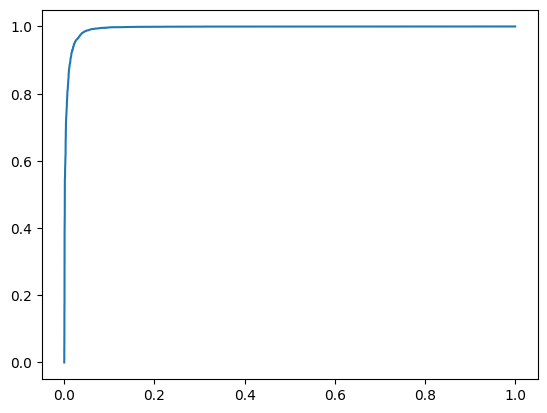

In [7]:

%autoreload 2


oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)

metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()


### DKNN

2023-02-22 19:23:29.951743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:23:36.811264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:23:54.193057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9986808250000001, 'fpr95tpr': 0.0044, 'accuracy_score': 0.5, 'roc_auc_score': 0.99868077}


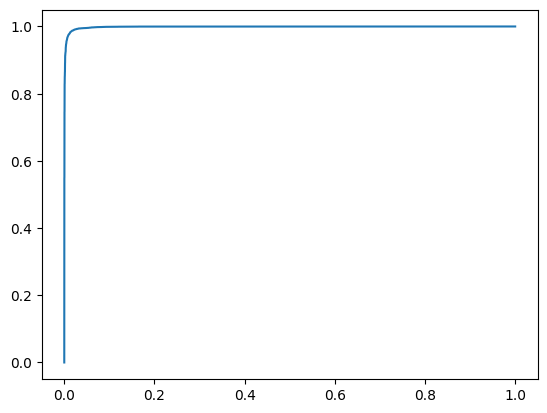

In [8]:
%autoreload 2


oodmodel = DKNN()
oodmodel.fit(model, ds_fit.take(10000))
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### ODIN

2023-02-22 19:23:56.260351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:23:56.805546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:23:59.797512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:23:59.980439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9946918650000001, 'fpr95tpr': 0.0216, 'accuracy_score': 0.97115, 'roc_auc_score': 0.9946919099999999}


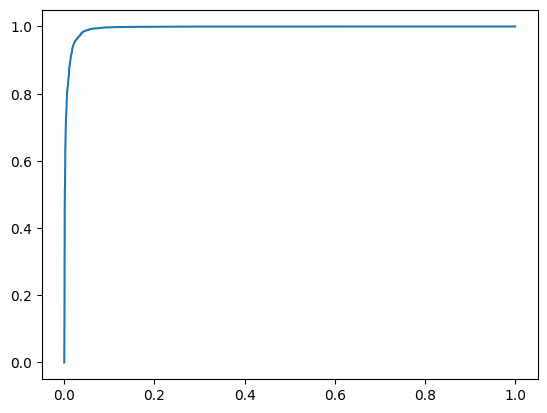

In [9]:

%autoreload 2
from oodeel.methods import ODIN

oodmodel = ODIN()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [19]:

%autoreload 2

oods_test = OODDataset('mnist', split="test")
oods_train = OODDataset('mnist', split="train")

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_id, _ = oods_train.assign_ood_labels_by_class(id_labels=inc_labels, return_filtered_ds=True)


Loading from tensorflow_datasets
Loading from tensorflow_datasets


2023-02-22 19:30:31.006494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:30:34.976276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:30:37.424330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:30:39.895526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [16]:

oods_test.assign_ood_labels_by_class(id_labels=inc_labels)

image_key = oods_test.input_key
labels = oods_test.ood_labels

def preprocess_fn(elem):
    elem[image_key] = elem[image_key] / 255
    return elem

ds_train = oods_id.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, training=True, 
with_ood_labels=False, shuffle_buffer_size=10000)
ds_test = oods_test.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_fit = oods_id.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

2023-02-22 19:28:58.639043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 19:28:59.413976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
%autoreload 2
from oodeel.models.training_funs import train_convnet_classifier

train_config = {
    "input_shape": (28, 28, 1),
    "num_classes": len(inc_labels),
    "is_prepared": True,
    "batch_size": 128,
    "epochs": 5
}

model = train_convnet_classifier(ds_train, **train_config)

2023-02-22 17:25:08.717258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5


2023-02-22 17:25:11.214586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - 8s 29ms/step - loss: 0.2163 - accuracy: 0.9365
Epoch 2/5
240/240 [==============================] - 6s 24ms/step - loss: 0.0492 - accuracy: 0.9858
Epoch 3/5
240/240 [==============================] - 5s 21ms/step - loss: 0.0321 - accuracy: 0.9913
Epoch 4/5
240/240 [==============================] - 5s 22ms/step - loss: 0.0292 - accuracy: 0.9923
Epoch 5/5
240/240 [==============================] - 5s 21ms/step - loss: 0.0283 - accuracy: 0.9924


## MLS

2023-02-22 17:25:40.211200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 17:25:40.840425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9518214056551466, 'fpr95tpr': 0.19887137575403774, 'accuracy_score': 0.8843, 'roc_auc_score': 0.9518199645413961}


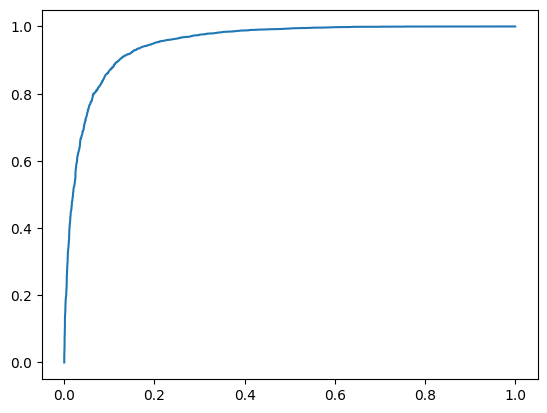

In [ ]:
%autoreload 2

oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### DKNN

2023-02-22 17:25:43.400152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 17:25:45.169745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 17:25:49.776173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9652932572409261, 'fpr95tpr': 0.1521696828176688, 'accuracy_score': 0.4861, 'roc_auc_score': 0.9652911556167068}


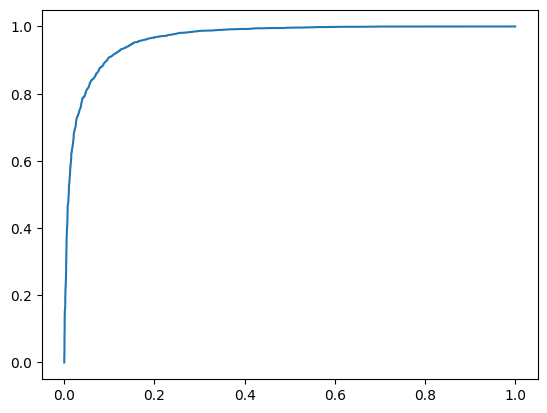

In [ ]:
%autoreload 2

oodmodel = DKNN()
oodmodel.fit(model, ds_fit.take(10000))
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### ODIN

2023-02-22 17:25:50.689513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 17:25:50.848053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 17:25:52.642078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 17:25:52.795903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.952706249497862, 'fpr95tpr': 0.19283907374975676, 'accuracy_score': 0.8683, 'roc_auc_score': 0.9527054488791117}


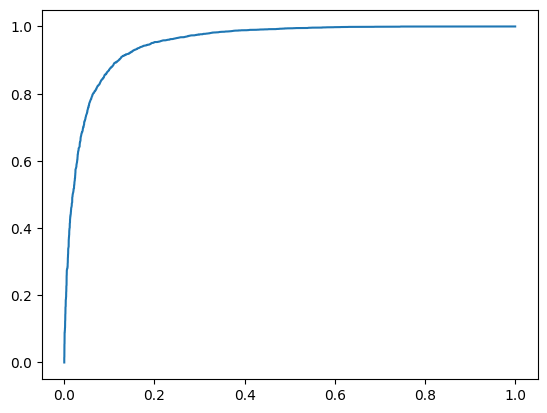

In [ ]:
%autoreload 2

#x_test, y_id = data_handler.convert_to_numpy(x_id)

oodmodel = ODIN()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()